In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
import time
import gym

In [2]:
relu = lambda t:np.maximum(0,t)
diff_relu = lambda t:1 if t >= 0 else 0
diff_relu = np.vectorize(diff_relu)
identite = lambda t:t
identite_diff = lambda t:1

In [3]:
C_quad = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_quad_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )

In [112]:
class Reseau_Neurones():
    def __init__(self, n0):
        self.n = [n0] #taille des couches successives -- n0 couche entrée
        self.L = 0  #nombre de couches
        # on utilise None en position 0 car les indices des couches commencent à 1
        self.W = [None] #contient les matrices None, W1, W2, ... WL
        self.b = [None] #contient les biais None, b1, b2, ... bL
        self.fa = [None] #fonctions d'activation None, f1, f2, ... fL
        self.diff_fa = [None] #dérivées des fa
        
        self.compteur_grad = 0
        
        
        #stockage des valeurs activ/preactiv (passe avant)
        self.a = None
        self.z = None
        
        #stockage des gradients (passe arrière)
        self.gw = [None]
        self.gb = [None]
        
    def ajout_couche(self, n_neurones, fa, diff_fa):
        new_W = np.random.normal(size=(n_neurones,self.n[-1]))
        new_b = np.random.normal(size=(n_neurones,1))
        self.n.append(n_neurones)
        self.W.append(new_W)
        self.gw.append(np.zeros(new_W.shape))
        
        self.b.append(new_b)
        self.gb.append(np.zeros(new_b.shape))
        
        self.fa.append(fa)
        self.diff_fa.append(diff_fa)
        self.L += 1
        assert self.L == len(self.n)-1 == len(self.W)-1 == len(self.b)-1 == len(self.fa)-1
        
    def propag_avant(self, x, log=True):
        if log:
            self.a = [x]
            self.z = [None]
        
        a = x
        for l in range(1,self.L+1):
            z = self.W[l].dot(a) + self.b[l]
            a = self.fa[l](z)
            if log: 
                self.z.append(z)
                self.a.append(a)
        #if a.shape==(1,1):
        return a
    
    def zero_gradient(self):
        self.compteur_grad = 0
        for l in range(1,self.L+1):
            self.gw[l] = np.zeros(self.gw[l].shape)
            self.gb[l] = np.zeros(self.gb[l].shape)
            
        
    
    def propag_arriere(self, diff_C):
        
        self.compteur_grad += 1
        
        ga = diff_C(self.a[self.L])

     
        
        for l in range(self.L,0,-1):
            #print(f"l = {l} ga= {ga}")
            gz = ga * self.diff_fa[l](self.z[l])
            #print(f"l = {l} gz= {gz}")
            gw = gz.dot(self.a[l-1].T)
            #print(f"l = {l} gw {gw.shape} w {self.W[l].shape}")
            gb = np.copy(gz)
            #print(f"l = {l} gb= {gb}")
            
            
            self.gw[l] += np.copy(gw)
            self.gb[l] += np.copy(gb)
            
            ga = self.W[l].T.dot(gz)
            
    def pas_gradient(self, pas, lambada = 0.001):
        # lambada constante de regularisation
        
        for l in range(1,self.L+1):
            #print(self.W[l].shape,self.gw[l].shape,"hop")
            self.W[l] = (1-lambada*pas)*self.W[l] - pas/self.compteur_grad*self.gw[l]
            self.b[l] = (1-lambada*pas)*self.b[l] - pas/self.compteur_grad*self.gb[l]
        
        

# test sur valeurs numériques connues

In [64]:
rn = Reseau_Neurones(2)
rn.ajout_couche(3, relu, diff_relu)
rn.ajout_couche(2, relu, diff_relu)
rn.ajout_couche(1, identite, diff_identite)

In [65]:
rn.W

[None,
 array([[ 1.71667811, -0.59984332],
        [ 0.48764457, -1.27518196],
        [ 1.07169724, -0.04317413]]),
 array([[ 0.48990446,  0.08995417, -0.25055634],
        [-0.50379166,  2.33120383, -0.65065858]]),
 array([[ 0.94194131, -0.25825506]])]

In [66]:
rn.W = [None,
 np.array([[0, -1],[ 2, -3],
        [ 1, -1]]),
 np.array([[ 0,  1,  -1],
        [ 2, -2, 1]]),
 np.array([[2, -1]])]

In [67]:
rn.b

[None,
 array([[-1.09385109],
        [-2.46247473],
        [-0.27313062]]),
 array([[ 1.49174885],
        [-0.34443263]]),
 array([[0.77158035]])]

In [68]:
rn.b = [None,
 np.array([[0],
        [ 1],
        [-1]]),
 np.array([[1],
        [-2]]),
 np.array([[0]])]

In [69]:
X = np.array([1,-2]).reshape((2,1))

In [70]:
rn.propag_avant(X)

16

In [71]:
rn.z

[None,
 array([[2],
        [9],
        [2]]),
 array([[  8],
        [-14]]),
 array([[16]])]

In [72]:
rn.a

[array([[ 1],
        [-2]]),
 array([[2],
        [9],
        [2]]),
 array([[8],
        [0]]),
 array([[16]])]

In [73]:
rn.zero_gradient()
rn.propag_arriere(C_quad_diff(cible=1))

[[30]]


In [74]:
rn.gw

[None,
 array([[   0.,    0.],
        [  60., -120.],
        [ -60.,  120.]]),
 array([[120., 540., 120.],
        [  0.,   0.,   0.]]),
 array([[240.,   0.]])]

In [75]:
rn.gb

[None,
 array([[  0.],
        [ 60.],
        [-60.]]),
 array([[60.],
        [ 0.]]),
 array([[30.]])]

In [61]:
C_quad_diff(1)(16)

array(0)

In [76]:
rn.pas_gradient(pas=1, lambada=0)

In [78]:
rn.W

[None,
 array([[   0.,   -1.],
        [ -58.,  117.],
        [  61., -121.]]),
 array([[-120., -539., -121.],
        [   2.,   -2.,    1.]]),
 array([[-238.,   -1.]])]

In [79]:
rn.b

[None,
 array([[  0.],
        [-59.],
        [ 59.]]),
 array([[-59.],
        [ -2.]]),
 array([[-30.]])]

# test fonction xor

In [80]:
xor = lambda x : 1 if x[0][0]*x[1][0] >= 0 else -1

In [338]:
M = 5000
X = np.random.uniform(-5,5,size=(2,M))
y = np.array([xor(X[:,[i]]) for i in range(M)])

In [339]:
C = lambda cible: np.vectorize( lambda y: -cible*y if y*cible < 0 else 0 )
C_diff = lambda cible: np.vectorize( lambda y: -cible if y*cible < 0 else 0 )

In [340]:
rn = Reseau_Neurones(2)
rn.ajout_couche(8, relu, diff_relu)
rn.ajout_couche(8, relu, diff_relu)
rn.ajout_couche(1, lambda t:t, lambda t:1)

In [341]:
print(rn.L, [rn.W[i].shape for i in range(1,rn.L+1)])

3 [(8, 2), (8, 8), (1, 8)]


In [342]:
for epoch in range(100000):
    i = epoch%M
    x = X[:,[i]]
    batch_size = 100
    
    rn.propag_avant(x)
    cdif = C_diff(y[i])
    rn.propag_arriere(cdif)
    if epoch % batch_size == 0:
        rn.pas_gradient(0.01, lambada=0)
        rn.zero_gradient()
    #print(rn.W)
    #input()
    #if i%10000 == 0:
        #y_pred = np.array([rn.propag_avant(X[:,[i]], log = False) for i in range(M)])
        #print(np.array([C(y[i])(y_pred[i]) for i in range(M)]).mean(),sep= " ")
    

In [343]:
pred = np.vectorize(lambda x1,x2: rn.propag_avant( np.array([[x1],[x2]]), log = False)  )

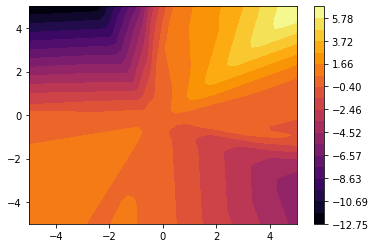

In [344]:
Xgraph = np.linspace(-5,5,50)
X1, X2 = np.meshgrid(Xgraph,Xgraph)
F = pred(X1,X2)
levels = np.linspace(np.min(F),np.max(F),20)
cp = plt.contourf(X1,X2, F,levels, cmap='inferno')
plt.colorbar(cp)  # pratique pour voir les valeurs
#plt.scatter(X[0,:],X[1,:],c=y)
plt.show()

In [345]:
# missclassified
y_pred = np.array([rn.propag_avant(X[:,[i]], log = False) for i in range(M)])
np.array([1 if y_pred[i]*y[i] < 0 else 0 for i in range(M)]).mean()

0.019

## test sur donnees

### droite non bruitée de dim 2

In [105]:
X00 = np.random.uniform(0,1,size=100).reshape(1,100)
Y00 = 3*X00 + 2

In [131]:
# un neurone 2 -> 1 sortie lineaire
rn = Reseau_Neurones(1)
rn.ajout_couche(1, lambda t:t, lambda t:1)
# coût quadratique
C = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )

In [150]:
m = X00.shape[1]  # 100 en principe
rn.zero_gradient()
batch_size = m
#print(rn.W[1])
#input()
for epoch in range(50000):
    i = epoch % m
    x = X00[:,[i]] #donnee a traiter
    y = Y00[0][i]
    #print(x,y)
    rn.propag_avant(x)
    cdif = C_diff(cible=y)
    rn.propag_arriere(cdif)
    if epoch % batch_size==0:
        #print(rn.W[1])
        #input()
        rn.pas_gradient(.01,lambada=0)
        rn.zero_gradient()

In [151]:
Y00_pred = np.array([rn.propag_avant(X00[:,[i]], log = False) for i in range(m)])
MSE00 = ((Y00_pred - Y00)**2).mean()
MSE00

0.0007526827100591059

In [99]:
X00[:,[10]]

array([[0.58637583]])

## droite bruitee

In [166]:
X01 = np.random.uniform(0,1,size=100).reshape(1,100)
Y01 = 3*X01 + 2 + 0.1*np.random.normal(size=(1,100))

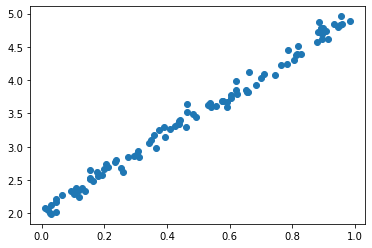

In [167]:
plt.scatter(X01[0],Y01[0])
plt.show()

In [187]:
import sklearn.linear_model
X01bis = X01.reshape(100,1)
Y01bis = Y01.reshape(100,1)
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X01bis,Y01bis)
Y01_pred=lin_reg.predict(X01bis)
MSE01 = ((Y01_pred - Y01bis)**2).mean()
MSE01

0.007240532524687522

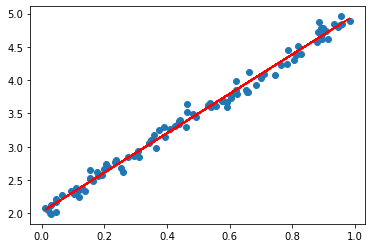

In [188]:
plt.scatter(X01[0],Y01[0])
plt.plot(X01[0],Y01_pred, c='red')
plt.show()

In [193]:
# un neurone 2 -> 1 sortie lineaire
rn = Reseau_Neurones(1)
rn.ajout_couche(1, lambda t:t, lambda t:1)
# coût quadratique
C = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )
m = X01.shape[1] 
rn.zero_gradient()
batch_size = m
#print(rn.W[1])
#input()
for epoch in range(50000):
    i = epoch % m
    x = X01[:,[i]] #donnee a traiter
    y = Y01[0][i]
    #print(x,y)
    rn.propag_avant(x)
    cdif = C_diff(cible=y)
    rn.propag_arriere(cdif)
    if epoch % batch_size==0:
        #print(rn.W[1])
        #input()
        rn.pas_gradient(.1,lambada=0)
        rn.zero_gradient()

In [194]:
Y01_pred_rn1 = np.array([rn.propag_avant(X01[:,[i]], log = False) for i in range(m)])

In [195]:
MSE01 = ((Y01_pred_rn1 - Y01)**2).mean()
MSE01

0.007241329660565622

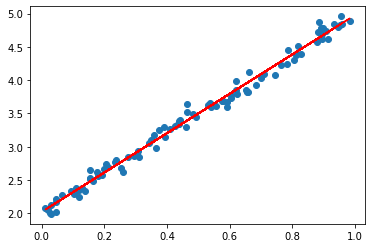

In [196]:
plt.scatter(X01[0],Y01[0])
plt.plot(X01[0],Y01_pred_rn1, c='red')
plt.show()

### meilleure approx avec reseau multicouche ?

In [203]:
# un neurone 2 -> 1 sortie lineaire
rn = Reseau_Neurones(1)
rn.ajout_couche(2, identite, identite_diff)
rn.ajout_couche(2, relu, diff_relu)
rn.ajout_couche(1, lambda t:t, lambda t:1)
# coût quadratique
C = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )
m = X01.shape[1] 
rn.zero_gradient()
batch_size = m
#print(rn.W[1])
#input()
for epoch in range(50000):
    i = epoch % m
    x = X01[:,[i]] #donnee a traiter
    y = Y01[0][i]
    #print(x,y)
    rn.propag_avant(x)
    cdif = C_diff(cible=y)
    rn.propag_arriere(cdif)
    if epoch % batch_size==0:
        #print(rn.W[1])
        #input()
        rn.pas_gradient(.1,lambada=0)
        rn.zero_gradient()

In [204]:
Y01_pred_rn1 = np.array([rn.propag_avant(X01[:,[i]], log = False) for i in range(m)])
MSE01 = ((Y01_pred_rn1 - Y01)**2).mean()
MSE01

0.008114778605147114

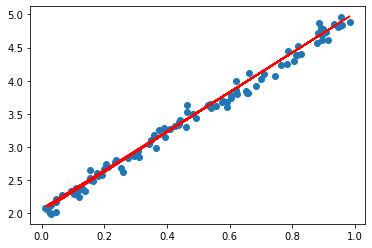

In [205]:
plt.scatter(X01[0],Y01[0])
plt.plot(X01[0],Y01_pred_rn1, c='red')
plt.show()

### sur une entree quadratique

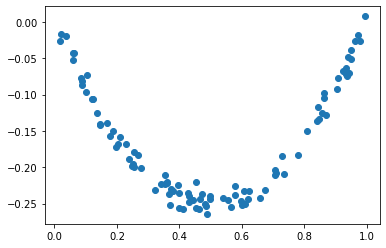

In [209]:
X02 = np.random.uniform(0,1,size=100).reshape(1,100)
Y02 = X02**2 - X02 + 0.01*np.random.normal(size=(1,100))
plt.scatter(X02[0],Y02[0])
plt.show()

In [210]:
X02bis = X02.reshape(100,1)
Y02bis = Y02.reshape(100,1)
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X02bis,Y02bis)
Y02_pred=lin_reg.predict(X02bis)
MSE02 = ((Y02_pred - Y02bis)**2).mean()
MSE02

0.00601913206043158

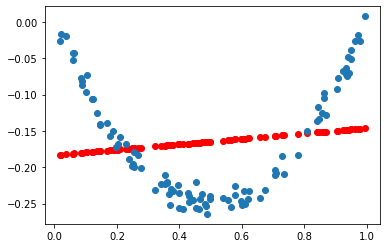

In [213]:
plt.scatter(X02[0],Y02_pred, c='red')
plt.scatter(X02bis,Y02bis)
plt.show()

In [230]:
rn = Reseau_Neurones(1)
rn.ajout_couche(3, relu, diff_relu)
rn.ajout_couche(1, lambda t:t, lambda t:1)
# coût quadratique
C = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )
m = X02.shape[1] 
rn.zero_gradient()
batch_size = 10
#print(rn.W[1])
#input()
for epoch in range(500000):
    i = epoch % m
    x = X02[:,[i]] #donnee a traiter
    y = Y02[0][i]
    #print(x,y)
    rn.propag_avant(x)
    cdif = C_diff(cible=y)
    rn.propag_arriere(cdif)
    if epoch % batch_size==0:
        #print(rn.W[1])
        #input()
        rn.pas_gradient(.1,lambada=0)
        rn.zero_gradient()

In [231]:
Y02_pred_rn2 = np.array([rn.propag_avant(X02[:,[i]], log = False) for i in range(m)])
MSE02 = ((Y02_pred_rn2 - Y02)**2).mean()
MSE02

0.000441726556322385

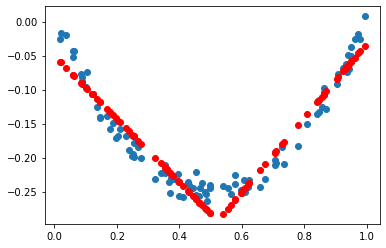

In [233]:
plt.scatter(X02[0],Y02[0])
plt.scatter(X02[0],Y02_pred_rn2, c='red')
plt.show()

### comparaison linear regression en approx pure

In [64]:
import sklearn as sk
from sklearn import datasets
diabetes = datasets.load_diabetes()

In [68]:
#print(diabetes['DESCR'])
#TLDR : 10 column prediction valeur reelles, target = mesure de la maladie

In [80]:
Xd0 = diabetes['data'] ; Yd0 = diabetes['target']
Xd0.shape, Yd0.shape

((442, 10), (442,))

In [81]:
lin_reg = sk.linear_model.LinearRegression()
lin_reg.fit(Xd0,Yd0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
Yd0_pred=lin_reg.predict(Xd0)

In [97]:
MSE0 = ((Yd0_pred - Yd0)**2).mean()
MSE0

2859.6903987680657

### comparaison avec neurone unique

In [141]:
# un neurone 10 -> 1 sortie lineaire
rn = Reseau_Neurones(10)
rn.ajout_couche(10, relu, diff_relu)
rn.ajout_couche(1, lambda t:t, lambda t:1)
# coût quadratique
C = lambda cible: np.vectorize( lambda y: (y-cible)**2 )
C_diff = lambda cible: np.vectorize( lambda y : 2*(y-cible) )
# données 
Xd1 = Xd0.T
Yd1 = Yd0

In [148]:
# grad stoch
m = Xd1.shape[1]  # 442 en principe
rn.zero_gradient()
batch_size = 100

for epoch in range(50000):
    i = epoch % m
    x = Xd1[:,[i]] #donnee a traiter
    rn.propag_avant(x)
    cdif = C_diff(Yd1[i])
    rn.propag_arriere(cdif)
    if epoch % batch_size==0:
        rn.pas_gradient(.01,lambada=0)
        rn.zero_gradient()
    #if i%10000 == 0:
    #    Yd1_pred = np.array([rn.propag_avant(X[:,[i]], log = False) for i in range(M)])
    #    print(np.array([C(y[i])(y_pred[i]) for i in range(M)]).mean(),sep= " ")

In [149]:
Yd1_pred = np.array([rn.propag_avant(Xd1[:,[i]], log = False) for i in range(m)])

In [150]:
MSE1 = ((Yd1_pred - Yd1)**2).mean()
MSE1

29074.481900452487

## tests de q-learning

### moutain car

In [8]:
env = gym.make('MountainCar-v0') ; env.reset()

array([-0.58200467,  0.        ])

In [297]:
env.observation_space.shape

(2,)

In [298]:
env.action_space

Discrete(3)

In [339]:
qa_approximator = Reseau_Neurones(4)
#entrée : 2 dimensions pour l'espace et 2 pour l'action G/D représentée par 1,0 et 0,1
# on ne tiendra pas compte du 1 qui est ne pas pousser
qa_approximator.ajout_couche(5, relu, diff_relu)
qa_approximator.ajout_couche(1, identite, identite_diff)

In [340]:
def eval_qa(machine, state, action1, action2, log=False):
    state_action = np.concatenate([state, np.array([[ action1],[ action2]])],axis=0)
    #print(state_action)
    return machine.propag_avant(state_action, log=log)

def epsilon_greedy(state, epsilon):
    r = np.random.random() 
    if r < epsilon/2:
        return 0
    elif r < epsilon:
        return 2
    else:
        vg = eval_qa(qa_approximator,  state, 1, 0, log=False)
        vd = eval_qa(qa_approximator,  state, 0, 1, log=False)
        #print(vg,vd)
        #print(state_action)
        #input("")
        if vg > vd:
            return 0
        else:
            return 2

In [345]:
alpha = 0.01
gamma = 0.8
nb_episodes = 500
old_cptr = 0
best_reward = -1000
for n in range(nb_episodes):
    #debut episode
    state = env.reset()
    state = state.reshape((2,1))
    terminal = False
    total_reward = 0

    while not terminal:
        
        if n % 100==0:
            #env.render()
            pass
        action = epsilon_greedy(state, 0.1)
        new_state, reward, terminal, info = env.step(action)
        total_reward += reward
        new_state = new_state.reshape((2,1))
        #update
        action1, action2 = [ (1,0), None, (0,1)][action]
        state_action = np.concatenate([state, np.array([[ action1],[ action2]])],axis=0)
        
        old_qa = qa_approximator.propag_avant(state_action, log=True)
        
        max_qa_new_state = np.max([ eval_qa(qa_approximator,  new_state, 1,0, log=False), 
                                  eval_qa(qa_approximator,  new_state, 0,1, log=False)] )
        #new_qa = (1-alpha)*old_qa + alpha*(reward + gamma*max_qa_new_state)
        #reward =  state[1]
        new_qa = reward + gamma*max_qa_new_state
        #if n%100==0:
        #    print(new_qa)
        
        cdif = C_diff(new_qa)
        old_qa = qa_approximator.propag_avant(state_action, log=True)
        qa_approximator.propag_arriere(cdif)
        qa_approximator.pas_gradient(pas = 0.01, lambada = 0.01)
        
        #debug
        """
        newold = eval_qa(qa_approximator, state, action)
        print(f"oldqa {old_qa} cible {new_qa} progress {newold} ")
        input()"""
        cptr += 1
    
    if total_reward >  best_reward:
        best_reward = total_reward
        print (total_reward, end=" ")
    

-200.0 

In [346]:
state = env.reset()
state = state.reshape((2,1))
print(state)
eval_qa(qa_approximator, state, 1,0), eval_qa(qa_approximator, state, 0,1)

[[-0.42926371]
 [ 0.        ]]


(-4.878048877529293, -4.878048877529293)

In [347]:
qa_approximator.W

[None,
 array([[ 5.27134334e-02,  9.94071692e-14, -3.07141370e-02,
         -4.30664725e-02],
        [ 2.17695046e-02, -7.11906236e-15, -1.07663222e-02,
         -9.91137478e-03],
        [ 6.91271202e-02, -9.84137783e-14, -1.06350966e-01,
         -1.80918819e-02],
        [ 9.72995650e-03,  2.14608079e-13, -1.53071463e-02,
          6.72434465e-14],
        [ 4.49517626e-02, -3.84687330e-14, -4.53885475e-02,
         -2.16655385e-02]]),
 array([[0.04921623, 0.04527806, 0.02349738, 0.01177756, 0.08128992]])]

In [25]:
##test de marde
state = env.reset()
terminal = False
while not terminal:
    env.render()
    if state[1] <0 :
        action = 0
    else:
        action=2
    state, reward, terminal, info = env.step(action)


In [26]:
env.close()

### cartpole

In [6]:
if not env:
    env = gym.make('CartPole-v1') ; env.reset()

array([-0.00906005,  0.04729921,  0.02697162, -0.0251919 ])

In [7]:
env.observation_space.shape

(4,)

In [81]:
env.action_space

Discrete(2)

In [113]:
qa_approximator = Reseau_Neurones(4)
qa_approximator.ajout_couche(3, relu, diff_relu)
qa_approximator.ajout_couche(2, identite, identite_diff)

In [149]:
state = env.reset().reshape((4,1))
res = qa_approximator.propag_avant(state, log=True)
res

array([[ 1.05827475],
       [-3.9143706 ]])

In [160]:
cdif = CG(val_cible=2)
res[0][0]

1.0582747501414753

In [165]:
cdif = CD_diff(2)

In [166]:
qa_approximator.propag_arriere(cdif)

In [167]:
qa_approximator.pas_gradient(pas=0.01)

In [127]:
np.max( qa_approximator.propag_avant(state, log=False)[:,0]) 

1.1044522400492573

In [157]:
#deux couts suivant gauche ou droite car y est de dim (2,1)
CG = lambda val_cible: np.vectorize( lambda y: (y[0][0]-cible)**2 )
CG_diff = lambda val_cible: lambda y : np.array([[2*(y[0][0]-val_cible)], [0]])
CD_diff = lambda val_cible: lambda y : np.array([[0],[2*(y[0][0]-val_cible)]])

import copy

In [120]:
def epsilon_greedy(state, epsilon):
    r = np.random.random() 
    if r < epsilon/2:
        return 0
    elif r < epsilon:
        return 1
    else:
        y = qa_approximator.propag_avant(state, log=False)
        vg = y[0][0]
        vd = y[1][0]
        #print(vg,vd)
        #print(state_action)
        #input("")
        if vg > vd:
            return 0
        else:
            return 1

In [174]:
alpha = 0.01
gamma = 0.9
nb_episodes = 50000
old_cptr = 0
best_reward = -1000
update_cptr = 0
list_rewards = []
history = []
max_history_length = 40000

target_rn = copy.deepcopy(qa_approximator)


for n in range(nb_episodes):
    #debut episode
    state = env.reset()
    state = state.reshape((4,1))
    terminal = False
    total_reward = 0

    while not terminal:
        update_cptr += 1
        
        if n % 100==0:
            #env.render()
            pass
        action = epsilon_greedy(state, 0.1)
        new_state, reward, terminal, info = env.step(action)
        new_state = new_state.reshape((4,1))
        
        if len(history)<max_history_length:
            history.append((state, action, reward, new_state))
        else:
            history[update_cptr%max_history_length] = (state, action, reward, new_state)
        
        total_reward += reward
        
        #sample_history et update
        state, action, reward, new_state = history[np.random.randint(0,len(history))]
              
        old_qa = qa_approximator.propag_avant(state, log=True)[action][0]
        
        max_qa_new_state = np.max( target_rn.propag_avant(new_state, log=False)[:,0])                            
        
        new_qa = reward + gamma*max_qa_new_state
        
        if action==0:
            cdif = CG_diff(new_qa)
        else:
            cdif = CD_diff(new_qa)
        #old_qa = qa_approximator.propag_avant(state_action, log=True)
        qa_approximator.propag_arriere(cdif)
        
        #if update_cptr%25==0:
        qa_approximator.pas_gradient(pas = 0.001, lambada = 0.01)
        qa_approximator.zero_gradient()
        if update_cptr%5000==0:
                target_rn = copy.deepcopy(qa_approximator)
        
        #debug
        """
        newold = eval_qa(qa_approximator, state, action)
        print(f"oldqa {old_qa} cible {new_qa} progress {newold} ")
        input()"""
        #cptr += 1
    list_rewards.append(total_reward)
    if total_reward >  best_reward:
        best_reward = total_reward
        print (total_reward, end=" ")


10.0 12.0 13.0 14.0 15.0 16.0 19.0 22.0 23.0 

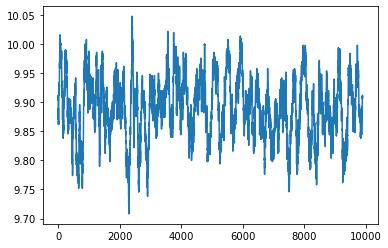

In [175]:
p = int(len(list_rewards)/100)
moyennes = [sum(list_rewards[i:i+p])/p for i in range(len(list_rewards)-p) ]
plt.plot(moyennes[::5])

In [70]:
    

state = env.reset()
state = state.reshape((4,1))
print(state)
eval_qa(qa_approximator, state, 1,0), eval_qa(qa_approximator, state, 0,1)

[[-0.02655295]
 [ 0.03970998]
 [-0.01319909]
 [-0.00065207]]


(9.95503472800184, 9.97517644597179)

In [53]:
qa_approximator.W

[None,
 array([[-3.34428718e-04,  8.05455023e-04,  1.11876599e-03,
         -2.23801606e-03, -5.45729950e-02, -2.05602221e-02],
        [ 1.55135745e-05,  3.41634906e-06, -1.58219075e-06,
         -3.22641179e-05, -9.43562573e-04, -2.51113969e-04],
        [-3.50934065e-03,  5.07263512e-03,  7.54932772e-03,
         -1.72788403e-02, -3.65111077e-01, -1.64123328e-01],
        [ 9.57232206e-05, -5.36461190e-06, -2.03268731e-05,
         -3.80519440e-06, -2.20584149e-05, -6.99234544e-05],
        [ 3.99916062e-05,  8.18962489e-05, -5.35569626e-05,
          1.81208546e-05, -1.20626308e-04, -1.72955537e-04]]),
 array([[-5.81314678e-02,  5.37986417e-04, -8.04386378e-01,
         -2.51729075e-06, -3.15854026e-05]])]

## toy environnement

In [247]:
class Toy():
    def __init__(self,n, hasard=0.1):
        self.n = n
        self.hasard = hasard
        self.state = 0
        
    def reset(self):
        self.state = 0
        return np.array(0)
        
    def step(self, action):
        r = np.random.random()
        if r < self.hasard /2:
            transition = -1
        elif r < self.hasard:
            transition = 1
        else:
            transition = 2*action-1
        
        self.state += transition
        
        if self.state >= self.n :
            terminal = True
            reward = 1
        elif self.state<= -self.n:
            terminal = True
            reward = 0
        else:
            terminal = False
            reward = 0
        
        return np.array(self.state), reward, terminal, "yo"

In [248]:
env = Toy(5)

In [249]:
env.reset()

array(0)

In [250]:
#deux couts suivant gauche ou droite car y est de dim (2,1)
CG = lambda val_cible: np.vectorize( lambda y: (y[0][0]-cible)**2 )
CG_diff = lambda val_cible: lambda y : np.array([[2*(y[0][0]-val_cible)], [0]])
CD_diff = lambda val_cible: lambda y : np.array([[0],[2*(y[0][0]-val_cible)]])

In [251]:
toy_rn= Reseau_Neurones(1)
toy_rn.ajout_couche(2, identite, identite_diff)

In [252]:
def epsilon_greedy(state, epsilon):
    r = np.random.random() 
    if r < epsilon/2:
        return 0
    elif r < epsilon:
        return 1
    else:
        y = toy_rn.propag_avant(state, log=False)
        vg = y[0][0]
        vd = y[1][0]
        #print(vg,vd)
        #print(state_action)
        #input("")
        if vg > vd:
            return 0
        else:
            return 1

In [257]:
alpha = 0.01
gamma = 0.9
nb_episodes = 50000
old_cptr = 0
best_reward = -1000
update_cptr = 0
list_rewards = []
history = []
max_history_length = 40000

target_rn = copy.deepcopy(toy_rn)


for n in range(nb_episodes):
    #debut episode
    state = env.reset()
    state = state.reshape((1,1))
    terminal = False
    total_reward = 0

    while not terminal:
        update_cptr += 1
        
        if n % 100==0:
            #env.render()
            pass
        action = epsilon_greedy(state, 0.1)
        new_state, reward, terminal, info = env.step(action)
        new_state = new_state.reshape((1,1))
        
        if len(history)<max_history_length:
            history.append((state, action, reward, new_state))
        else:
            history[update_cptr%max_history_length] = (state, action, reward, new_state)
        
        total_reward += reward
        
        #sample_history et update
        state, action, reward, new_state = history[np.random.randint(0,len(history))]
              
        old_qa = toy_rn.propag_avant(state, log=True)[action][0]
        
        max_qa_new_state = np.max( target_rn.propag_avant(new_state, log=False)[:,0])                            
        
        new_qa = reward + gamma*max_qa_new_state
        
        if action==0:
            cdif = CG_diff(new_qa)
        else:
            cdif = CD_diff(new_qa)
        #old_qa = qa_approximator.propag_avant(state_action, log=True)
        toy_rn.propag_arriere(cdif)
        
        #if update_cptr%25==0:
        toy_rn.pas_gradient(pas = 0.001, lambada = 0.01)
        toy_rn.zero_gradient()
        if update_cptr%5000==0:
                target_rn = copy.deepcopy(toy_rn)
        

        #cptr += 1
    list_rewards.append(total_reward)
    if total_reward >  best_reward:
        best_reward = total_reward
        print (total_reward, end=" ")


0 1 

### test q - learning tabulaire

In [273]:
def epsilon_greedy(qa, state, epsilon):
    if (state,0) not in qa:
        qa[(state,0)] = 0
    if (state,1) not in qa:
        qa[(state,1)] = 0
    r = np.random.random() 
    if r < epsilon/2:
        return 0
    elif r < epsilon:
        return 1
    else:

        vg = qa[(state,0)]
        vd = qa[(state,1)]
        if vg > vd:
            return 0
        else:
            return 1

In [318]:
qa = {}
alpha = 0.01
gamma = 0.9
nb_episodes = 50000
old_cptr = 0
best_reward = -1000
update_cptr = 0
list_rewards = []

for n in range(nb_episodes):
    #debut episode
    state = int(env.reset())
    terminal = False
    total_reward = 0

    while not terminal:
        update_cptr += 1
        
        action = epsilon_greedy(qa, state, 0.75)
        #print((state,action), end=" ")
        new_state, reward, terminal, info = env.step(action)
        new_state = int(new_state)
        #print(new_state, reward, terminal, info)
        
        total_reward += reward
        if (new_state,0) not in qa:
            qa[(new_state,0)] = 0
        if (new_state,1) not in qa:
            qa[(new_state,1)] = 0
        max_qa_new_state = max( qa[(new_state,0)], qa[(new_state,1)])
        
        new_qa = reward + gamma*max_qa_new_state
        
        qa[(state,action)] = (1-alpha)* qa[(state,action)]  + alpha*new_qa
        
        state = new_state


    list_rewards.append(total_reward)
    if total_reward >  best_reward:
        best_reward = total_reward
        print (total_reward, end=" ")


1 

In [319]:
state

5

In [320]:
for x in range(-4,5):
    target = gamma**(5-x-1)
    val = qa[(x,1)]
    print((val - target)/target*100)

-12.97933336476478
-7.785152695517277
-7.267058131813665
-5.258878627905395
-4.69023381903961
-4.532301496011692
-3.8284829243196006
-2.2053958554246864
-0.8644376685922772


In [321]:
qa

{(0, 0): 0.5054871823421291,
 (0, 1): 0.6253273759132811,
 (1, 0): 0.5708487127584061,
 (1, 1): 0.6959595220940749,
 (2, 0): 0.6385363233439915,
 (2, 1): 0.7789892883130113,
 (3, 0): 0.7127113362457235,
 (3, 1): 0.8801514373011778,
 (4, 0): 0.8112915238873188,
 (4, 1): 0.9913556233140772,
 (5, 0): 0,
 (5, 1): 0,
 (-1, 0): 0.45125699630734917,
 (-1, 1): 0.5594368475900815,
 (-2, 0): 0.4051562997082961,
 (-2, 1): 0.4928208735937082,
 (-3, 0): 0.3400028399290953,
 (-3, 1): 0.4410607559970745,
 (-4, 0): 0.013340424845094897,
 (-4, 1): 0.374595435788098,
 (-5, 0): 0,
 (-5, 1): 0}